In [1]:
%matplotlib widget
%reset -f
%load_ext autoreload
%autoreload 1
%aimport mechanics

from sympy import *
from mechanics import *
import mechanics.config

mechanics.config.diff_notations = {}

t, x = base_spaces('t x')

u, = variables('u', t, x)
c, L = constants('c L')
    
eq = {diff(u, t, t): c**2 * diff(u, x, x)}
show_equations(eq)

bc = {diff(u, x).subs(x, 0): 0, diff(u, x).subs(x, L): 0}
show_equations(bc)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
from mechanics.difference import second_central, central
from mechanics.space import Z

i, j = indices('i j')
h, k = constants('h k')
N, M = constants('N M', space=Z)

d = discretization()\
    .space(t, i, h).diff(t, second_central)\
    .space(x, j, k).diff(x, second_central).diff(x, central)

u = d(u)

eq_d = d(eq)
show_equations(eq_d)

eq_d = solve(to_implicit(eq_d), u[i+1,j])
show_equations(eq_d)

bc_d = d(bc)
show_equations(bc_d)
bc_d = solve((f.subs(L/k, M) for f in to_implicit(bc_d)), (u[:,-1], u[:,M+1]))
show_equations(bc_d)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
%autoreload
solver = build_solver()
solver.constants(c, h, k, N, M)
solver.variables(u, indices=((i, -1, N), (j, -1, M+1)))
solver.inputs(u[0,:], u[-1,:])
with solver.steps(i, 0, N) as step_time:
    step_time.explicit(bc_d)
    with step_time.steps(j, 0, M+1) as step_space:
        step_space.explicit(eq_d)
solver = solver.generate()

Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp7dgzvoax/generated.f90


In [13]:
%autoreload
import numpy as np

_ = solver.run({
    c: 1.0, 
    h: 0.01, k: 0.01, 
    N: 100, M: 100,
    u[0,:]:  1 - np.tanh((np.arange(-1, 102) * 0.01 - 0.5) * 5)**2,
    u[-1,:]: 1 - np.tanh((np.arange(-1, 102) * 0.01 - 0.5) * 5)**2,
})

Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmp8iahwpbh/result.log, size=10511


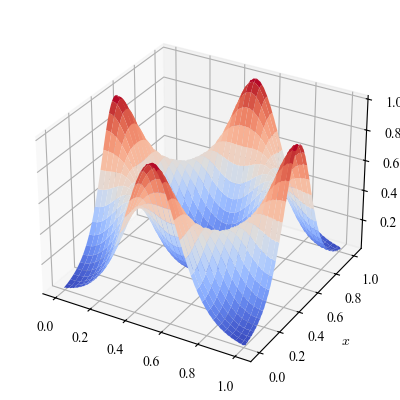

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

# t = np.arange(0, _[T], _[h])

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"projection": "3d"}, tight_layout=True)
T = np.arange(0, _[N]+2) * _[h]
X = np.arange(-1, _[M]+2) * _[k]
T, X = np.meshgrid(T, X, indexing='ij')
ax.plot_surface(T, X, _[u], cmap='coolwarm')
ax.set_ylabel('$x$')
ax.set_zlabel('$u$')
plt.show()
